In [6]:
import mbuild
import foyer
import mosdef_cassandra as mc
from mosdef_cassandra.analysis import ThermoProps
import unyt as u
import matplotlib.pyplot as plt
import numpy as np

# We'll filter out warnings. This is to improve the
# clarity of this tutorial. Please refrain to do this
# if you are not completely sure what these mean.

from warnings import filterwarnings
filterwarnings('ignore', category=UserWarning)

In [4]:
# Simulation settings 

temperature = 400.0
pressure = 5.39
boxl = 3.0
nmols = 200
simlength = 3000000
reference = 672.0
start = 1500000

In [8]:
# Use mbuild to create molecules
ethanol = mbuild.load("ethanol.mol2")

# Create an empty mbuild.Box
box = mbuild.Box(lengths=[boxl, boxl, boxl])

# Load force field
trappe = foyer.Forcefield(name="trappe-ua")

# Use foyer to apply force field
ethanol = trappe.apply(ethanol)

# Create box and species list
box_list = [box]
species_list = [ethanol]

# Use Cassandra to insert some initial number of species
mols_to_add = [[nmols]]

# Define the System
system = mc.System(box_list, species_list, mols_to_add=mols_to_add)
# Define the MoveSet
moveset = mc.MoveSet("npt", species_list)

# Here we must specify the pressure since we are performing a
# NpT simulation. It can be provided in the custom_args dictionary
# or as a keyword argument to the "run" function.
custom_args = {
    "pressure": pressure * u.bar,
}

# Run a simulation with at 400 K with 3E6 MC moves

# Damped shifted force for fast electrostatics

mc.run(
    system=system,
    moveset=moveset,
    charge_style="dsf",
    dsf_damping=0.2,
    run_type="equilibration",
    run_length=simlength,
    temperature=temperature * u.K,
    **custom_args,
)

Using the following executables for Cassandra:
Python: /home/emarinri/miniconda3/envs/cassandra/bin/python
library_setup: /home/emarinri/miniconda3/envs/cassandra/bin/library_setup.py
Cassandra: /home/emarinri/miniconda3/envs/cassandra/bin/cassandra.exe
Generating fragment libraries...
Running Cassandra...


In [ ]:
# Ewald summation

#mc.run(
#    system=system,
#    moveset=moveset,
#    run_type="equilibration",
#    run_length=simlength,
#    temperature=temperature * u.K,
#    **custom_args,
#)

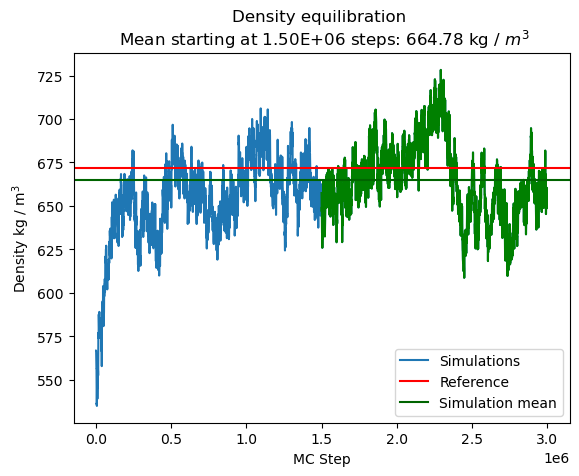

In [7]:
thermo = ThermoProps("./npt.out.prp")
density = thermo.prop("Mass_Density")

idx = np.where(thermo.prop("MC_STEP") >= start)[0][0]
plt.plot(thermo.prop("MC_STEP"), density, label="Simulations")
plt.plot(thermo.prop("MC_STEP")[idx:], density[idx:], color="green")
plt.axhline(reference, color='r', linestyle='-', label='Reference')
mean = np.mean(density[idx:])
plt.axhline(mean, color='darkgreen', linestyle='-', label='Simulation mean')
plt.title(f"Density equilibration \n Mean starting at {start:.2E} steps: {np.round(mean, 2)} kg / $m^3$")
plt.xlabel("MC Step")
plt.ylabel("Density kg / m$^3$")
plt.legend(loc="lower right")
plt.show()